In [1]:
import torch
import sys
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
import yaml
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.metrics import classification_report
import importlib.util
import glob
from PIL import Image
from sklearn.metrics import confusion_matrix

In [2]:
from shutil import copyfile

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [4]:
## User Param
# Amazon
args = {'dataset':'amazon',
        'folder_name':'/home/yoyo/Desktop/SimCLR/runs/amazon_Jul05_23-00-54_iter200_yoyo',
        'tag':'agri'
        }
# # Oil Palm
# args = {'dataset':'oilpalm',
#         'folder_name':'/home/yoyo/Desktop/SimCLR/runs_oilpalm/Jul05_21-43-21_iter200_lr1e-4_yoyo',
#         'tag':'palm'
#         }

args['tag'] = 'palm'
args['dataset'] = 'oilpalm'

DEBUG = False

In [5]:
args

{'dataset': 'oilpalm',
 'folder_name': '/home/yoyo/Desktop/SimCLR/runs/amazon_Jul05_23-00-54_iter200_yoyo',
 'tag': 'palm'}

In [6]:
checkpoints_folder = os.path.join(args['folder_name'], 'checkpoints')
config = yaml.full_load(open(os.path.join(checkpoints_folder, "config.yaml"), "r"))
config

{'batch_size': 256,
 'epochs': 200,
 'eval_every_n_epochs': 1,
 'fine_tune_from': 'None',
 'log_every_n_steps': 50,
 'weight_decay': '10e-6',
 'fp16_precision': False,
 'model': {'out_dim': 256, 'base_model': 'resnet18'},
 'dataset': {'s': 1,
  'input_shape': '(128,128,3)',
  'num_workers': 0,
  'valid_size': 0.1},
 'loss': {'temperature': 0.5, 'use_cosine_similarity': True}}

In [7]:
checkpoints_folder

'/home/yoyo/Desktop/SimCLR/runs/amazon_Jul05_23-00-54_iter200_yoyo/checkpoints'

In [8]:
def _load_data(prefix="train", img_size=128):
    img_list = glob.glob('../data/satellite/' + args['dataset'] + '/' + prefix + '/**/*')
    np.random.shuffle(img_list)
    X_train = []
    for f in img_list:
        img = Image.open(f).convert('RGB').resize((img_size, img_size))
        X_train.append(img)
        img.load()
    X_train = np.stack(X_train).transpose(0,3,1,2)
    
    y_train = np.array([f.split('/')[-2] == args['tag'] for f in img_list])
    
    print("===  {} dataset ===".format(args['dataset']))
    print("{} images".format(prefix))
    print(X_train.shape)
    print(y_train.shape)
    return X_train, y_train, img_list

In [9]:
# load facemask train data
X_train, y_train, train_list = _load_data("train")

===  oilpalm dataset ===
train images
(187, 3, 128, 128)
(187,)


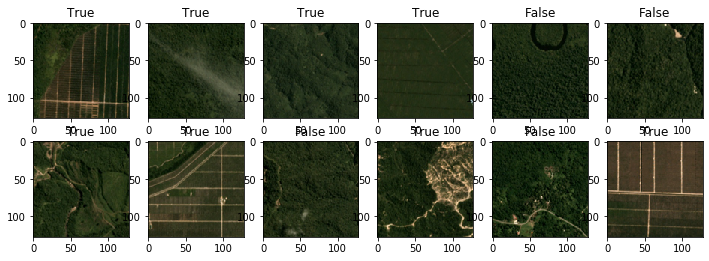

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=6, constrained_layout=False, figsize=(12,4))

for i, ax in enumerate(axs.flat):
    ax.imshow(X_train[i].transpose(1,2,0))
    ax.title.set_text(y_train[i])
plt.show()

In [11]:
# load facemask test data
X_test, y_test, unlbl_list = _load_data("unlabeled")

===  oilpalm dataset ===
unlabeled images
(1505, 3, 128, 128)
(1505,)


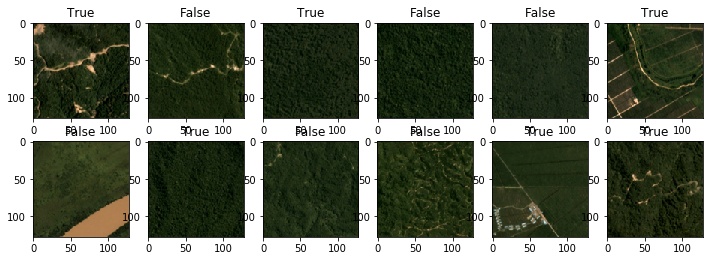

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=6, constrained_layout=False, figsize=(12,4))

for i, ax in enumerate(axs.flat):
    ax.imshow(X_test[i].transpose(1,2,0))
    ax.title.set_text(y_test[i])
plt.show()

## Test protocol #1 PCA features

In [13]:
# scaler = preprocessing.StandardScaler()
# scaler.fit(X_train.reshape((X_train.shape[0],-1)))

# pca = PCA(n_components=min(config['model']['out_dim'], X_train.shape[0]))

# X_train_pca = pca.fit_transform(scaler.transform(X_train.reshape(X_train.shape[0], -1)))
# X_test_pca = pca.transform(scaler.transform(X_test.reshape(X_test.shape[0], -1)))

# print("PCA features")
# print(X_train_pca.shape)
# print(X_test_pca.shape)

In [14]:
def linear_model_eval(X_train, y_train, X_test, y_test):
    if args['dataset'] == 'amazon':
        tag = 'agri'
    else:
        tag = 'palm'
    
    clf = LogisticRegression(max_iter=1200, solver='lbfgs', C=10.0)
    clf.fit(X_train, y_train)
    print("Logistic Regression feature eval")
    print("Train score:", clf.score(X_train, y_train))
    print("Test score:", clf.score(X_test, y_test))
    logis_pred = clf.predict(X_test)
    # show a nicely formatted classification report
    logis_dict = classification_report(y_test, logis_pred, target_names=['no_'+tag, tag], digits=3, output_dict=True)
    print(classification_report(y_test, logis_pred, target_names=['no_'+tag, tag], digits=3))
    logis_dict['confusion_matrix'] = confusion_matrix(y_test, logis_pred)
    print(logis_dict['confusion_matrix'])
    
    print("-------------------------------")
    svm = SVC()
    svm.fit(X_train, y_train)
    print("SVM feature eval")
    print("Train score:", svm.score(X_train, y_train))
    print("Test score:", svm.score(X_test, y_test))
    svm_pred = svm.predict(X_test)
    # show a nicely formatted classification report
    svm_dict = classification_report(y_test, svm_pred, target_names=['no_'+tag, tag], digits=3, output_dict=True)
    print(classification_report(y_test, svm_pred, target_names=['no_'+tag, tag], digits=3))
    svm_dict['confusion_matrix'] = confusion_matrix(y_test, svm_pred)
    print(svm_dict['confusion_matrix'])
    
    print("-------------------------------")
    neigh = KNeighborsClassifier(n_neighbors=10)
    neigh.fit(X_train, y_train)
    print("KNN feature eval")
    print("Train score:", neigh.score(X_train, y_train))
    print("Test score:", neigh.score(X_test, y_test))
    knn_pred = neigh.predict(X_test)
    # show a nicely formatted classification report
    knn_dict = classification_report(y_test, knn_pred, target_names=['no_'+tag, tag], digits=3, output_dict=True)
    print(classification_report(y_test, knn_pred, target_names=['no_'+tag, tag], digits=3))
    knn_dict['confusion_matrix'] = confusion_matrix(y_test, knn_pred)
    print(knn_dict['confusion_matrix'])
    
#     with open(pickle_file,"wb") as f:
#         pickle.dump([args, config, logis_dict, svm_dict, knn_dict],f)

    return logis_pred, svm_pred, knn_pred

In [15]:
# linear_model_eval(X_train_pca, y_train, X_test_pca, y_test)

# ## clean up resources
# del X_train_pca
# del X_test_pca

## Protocol #2 Logisitc Regression

In [16]:
# Load the neural net module
spec = importlib.util.spec_from_file_location("model", os.path.join(checkpoints_folder, '../../../models/resnet_simclr.py'))
resnet_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(resnet_module)

In [17]:
model = resnet_module.ResNetSimCLR(**config['model'])
model.eval()

state_dict = torch.load(os.path.join(checkpoints_folder, 'model.pth'), map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model = model.to(device)

Feature extractor: resnet18


In [18]:
def next_batch(X, y, batch_size):
    for i in range(0, X.shape[0], batch_size):
        X_batch = torch.tensor(X[i: i+batch_size]) / 255.
        y_batch = torch.tensor(y[i: i+batch_size])
        yield X_batch.to(device), y_batch.to(device)

In [19]:
X_train_feature = []

for batch_x, batch_y in next_batch(X_train, y_train, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_train_feature.extend(features.cpu().detach().numpy())
    
X_train_feature = np.array(X_train_feature)

print("Train features")
print(X_train_feature.shape)

Train features
(187, 512)


In [20]:
X_test_feature = []

for batch_x, batch_y in next_batch(X_test, y_test, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_test_feature.extend(features.cpu().detach().numpy().reshape((-1,512)))
    
X_test_feature = np.array(X_test_feature)

print("Test features")
print(X_test_feature.shape)

Test features
(1505, 512)


In [21]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_feature)

logis_pred, svm_pred, knn_pred = linear_model_eval(scaler.transform(X_train_feature), y_train, scaler.transform(X_test_feature), y_test)

del X_train_feature
del X_test_feature

Logistic Regression feature eval
Train score: 1.0
Test score: 0.6033222591362126
              precision    recall  f1-score   support

     no_palm      0.611     0.625     0.618       773
        palm      0.594     0.581     0.587       732

    accuracy                          0.603      1505
   macro avg      0.603     0.603     0.603      1505
weighted avg      0.603     0.603     0.603      1505

[[483 290]
 [307 425]]
-------------------------------
SVM feature eval
Train score: 0.8288770053475936
Test score: 0.639202657807309
              precision    recall  f1-score   support

     no_palm      0.662     0.609     0.634       773
        palm      0.619     0.671     0.644       732

    accuracy                          0.639      1505
   macro avg      0.640     0.640     0.639      1505
weighted avg      0.641     0.639     0.639      1505

[[471 302]
 [241 491]]
-------------------------------
KNN feature eval
Train score: 0.7112299465240641
Test score: 0.6372093023255

In [22]:
m = {0:'no'+args['tag'], 1:args['tag']}

In [23]:
n = len(svm_pred)
n_spl = int(n*1.0)

In [24]:
len(logis_pred[:n_spl])

1505

In [25]:
for name, pred in {'logis':logis_pred, 'svm':svm_pred, 'knn':knn_pred}.items():
# for name, pred in {'svm':svm_pred}.items():
    output_dir = '../data/satellite/' + args['dataset'] + '/transfer_predict_' + name + '/'
#     output_dir = '../data/satellite/' + args['dataset'] + '/predict/'
    if not os.path.exists(output_dir + 'no'+args['tag']):
        os.makedirs(output_dir + 'no'+args['tag'])
    if not os.path.exists(output_dir + args['tag']):
        os.makedirs(output_dir + args['tag'])
    
    count = 0
    for src, p in zip(unlbl_list[:n_spl], pred[:n_spl]):
        tokens = os.path.basename(src)
        dst = output_dir + m[p] + '/' + tokens
        copyfile(src, dst)
        count += 1
    print('pseudo label: ', count)
    
    count = 0
    for src in train_list:
        tokens = src.split('/')
        dst = output_dir + tokens[-2] + '/' + tokens[-1]
        copyfile(src, dst)
        count += 1
    print('read label: ', count)
    print('Done')

pseudo label:  1505
read label:  187
Done
pseudo label:  1505
read label:  187
Done
pseudo label:  1505
read label:  187
Done
